In [1]:
import snscrape.modules.twitter as stwitter
import pandas as pd
import numpy as np
import pickle as pkl 
from datetime import datetime
import datetime as dt
import string 
import re 
import emoji 


import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import TruncatedSVD



from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.util import ngrams


from itertools import combinations
from sklearn import decomposition
import gensim 


import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/hannahkim/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hannahkim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_pickle('df_clean.pkl')
df

,datetime,url,content,username,like_count
0,2020-01-01 00:00:43+00:00,https://twitter.com/helloamygarner/status/1212...,I stopped being a meat-loving disaster in the ...,helloamygarner,0
1,2020-01-01 00:04:29+00:00,https://twitter.com/Taertebjerg/status/1212162...,Arnold Schwarzenegger has ditched meat and dai...,Taertebjerg,0
2,2020-01-01 00:31:12+00:00,https://twitter.com/plantpowercoupl/status/121...,What?!?!?!?!?!?!?\n\nFYI - this is one of thos...,plantpowercoupl,3
3,2020-01-01 00:31:33+00:00,https://twitter.com/FurForceFive/status/121216...,Reducing your meat &amp; dairy intake can help...,FurForceFive,1
4,2020-01-01 01:32:27+00:00,https://twitter.com/CatMumof4/status/121218478...,@KFC_UKI What plant based products will be use...,CatMumof4,0
...,...,...,...,...,...
33575,2022-10-13 20:10:00+00:00,https://twitter.com/LotusHealthInst/status/158...,It's all fun and games or is it? #vegetarian #...,LotusHealthInst,0
33576,2022-10-13 20:16:44+00:00,https://twitter.com/th3awkwardvegan/status/158...,@luellensynergyq If it’s things like beyond bu...,th3awkwardvegan,1
33577,2022-10-13 20:27:31+00:00,https://twitter.com/luellensynergyq/status/158...,@th3awkwardvegan That would be fine with me to...,luellensynergyq,1
33578,2022-10-13 20:50:35+00:00,https://twitter.com/TheCoopInBham/status/15806...,"Frozen pizza is a classic, easy meal for all. ...",TheCoopInBham,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33580 entries, 0 to 33579
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   datetime    33580 non-null  datetime64[ns, UTC]
 1   url         33580 non-null  object             
 2   content     33580 non-null  object             
 3   username    33580 non-null  object             
 4   like_count  33580 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(1), object(3)
memory usage: 1.3+ MB


See random sample of text 

In [4]:
df_content_sample = df.content.sample(n=5).values
print(df_content_sample)

['For lunch today, my meat-loving parents ate a bowl of my vegan chorizo chili with vegan cornbread I made, and they really liked it. \n\nMom thought it had ground animal meat in it and I told her it was soy chorizo. She was like ok cool.😁 \n\n#plantbased #vegan #EPICclimateaction'
 'These adverts saying eating plant based is better for the environment make me feel so guilty for eating meat and I can’t help but feel kinda pissed for all the people who genuinely couldn’t go veggie/ vegan for health reasons. Guilt tripping isn’t it 🤦🏻\u200d♀️'
 "@jackcoleman97 @whatsaiah @thabo__ Eating poor plant based food solutions is the tasteless route to me, it would sobber up my high.\n\nEating vegan food thats substitution meat in a vegan entre is expensive, I've tried and looked, just eating it knowing the price would probably ruin my high too."
 '@Oneiropsis Maybe you\'re right.\n\nIt\'s just that the whole "plant based" narrative is still being pushed by many mainstream entities.\n\nAll that f

Clean Text: Remove punctuation, emoji, numbers, tags

In [5]:
newline = '\n'

def clean_text(text): 

 
    
    #convert text to lower case:
    text = str(text).lower()
    
    #remove url (https://): 
    text = re.sub('https:\S+', '', text)
    
    #remove tag (@):
    text = re.sub('@\S+', '', text)
    
    #remove hashtag:
    text = re.sub('#\S+', '', text)
    
    #remove html markup 
    text = re.sub("(<.*?\>)","",text)
    

    #remove emoji:
    text = emoji.replace_emoji(text, '')
    
    #remove digits:
    text = re.sub('\d+', '', text)
    
    #remove punctuation: 
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    
    #remove extra spaces: 
    text = re.sub(' +', ' ', text)
    
    #remove newline 
    if newline in text: 
        text = text.replace('\n', '')



    return text


In [6]:
df['clean_text'] = df.apply(lambda x: clean_text(x['content']) , axis =1)


Check for duplicates

In [7]:
duplicates_df = df[df.clean_text.duplicated()]
duplicates_df

,datetime,url,content,username,like_count,clean_text
18,2020-01-01 10:10:24+00:00,https://twitter.com/helloamygarner/status/1212...,I stopped being a meat-loving disaster in the ...,helloamygarner,1,i stopped being a meat loving disaster in the ...
55,2020-01-02 05:22:18+00:00,https://twitter.com/letsgoviralnow/status/1212...,Arnold Schwarzenegger has ditched meat and dai...,letsgoviralnow,0,arnold schwarzenegger has ditched meat and dai...
107,2020-01-02 20:05:57+00:00,https://twitter.com/theibsdietitian/status/121...,Seitan and Vegan IBS Seitan is a popular meat ...,theibsdietitian,0,seitan and vegan ibs seitan is a popular meat ...
135,2020-01-03 04:30:05+00:00,https://twitter.com/adage/status/1212954257709...,Meat Loaf's new manager pushes a vegan makeove...,adage,12,meat loaf s new manager pushes a vegan makeove...
137,2020-01-03 04:35:25+00:00,https://twitter.com/AnalyticaGlobal/status/121...,Meat Loaf's new manager pushes a vegan makeove...,AnalyticaGlobal,0,meat loaf s new manager pushes a vegan makeove...
...,...,...,...,...,...,...
33560,2022-10-13 15:00:02+00:00,https://twitter.com/foodstoriesnow/status/1580...,Grow your plant-based dining options at NYC ve...,foodstoriesnow,0,grow your plant based dining options at nyc ve...
33564,2022-10-13 15:47:10+00:00,https://twitter.com/ChicagoPlantEat/status/158...,"According to this @Harvard study, if everyone ...",ChicagoPlantEat,0,according to this study if everyone were to gi...
33568,2022-10-13 17:50:55+00:00,https://twitter.com/Animal_Posting/status/1580...,"""Peace in all lives""\nWhy do we repeat #violen...",Animal_Posting,0,peace in all lives why do we repeat against g...
33570,2022-10-13 18:21:01+00:00,https://twitter.com/SanjhaRTE/status/158062466...,🌱We're upping our plant-based game here at San...,SanjhaRTE,0,we re upping our plant based game here at sanj...


In [8]:
#drop duplicates   , 
df.drop_duplicates(subset = 'clean_text',ignore_index =True,inplace = True)
df

,datetime,url,content,username,like_count,clean_text
0,2020-01-01 00:00:43+00:00,https://twitter.com/helloamygarner/status/1212...,I stopped being a meat-loving disaster in the ...,helloamygarner,0,i stopped being a meat loving disaster in the ...
1,2020-01-01 00:04:29+00:00,https://twitter.com/Taertebjerg/status/1212162...,Arnold Schwarzenegger has ditched meat and dai...,Taertebjerg,0,arnold schwarzenegger has ditched meat and dai...
2,2020-01-01 00:31:12+00:00,https://twitter.com/plantpowercoupl/status/121...,What?!?!?!?!?!?!?\n\nFYI - this is one of thos...,plantpowercoupl,3,what fyi this is one of those people who say p...
3,2020-01-01 00:31:33+00:00,https://twitter.com/FurForceFive/status/121216...,Reducing your meat &amp; dairy intake can help...,FurForceFive,1,reducing your meat amp dairy intake can help m...
4,2020-01-01 01:32:27+00:00,https://twitter.com/CatMumof4/status/121218478...,@KFC_UKI What plant based products will be use...,CatMumof4,0,what plant based products will be used i m ho...
...,...,...,...,...,...,...
28868,2022-10-13 20:10:00+00:00,https://twitter.com/LotusHealthInst/status/158...,It's all fun and games or is it? #vegetarian #...,LotusHealthInst,0,it s all fun and games or is it if the meat in...
28869,2022-10-13 20:16:44+00:00,https://twitter.com/th3awkwardvegan/status/158...,@luellensynergyq If it’s things like beyond bu...,th3awkwardvegan,1,if it’s things like beyond burgers and other ...
28870,2022-10-13 20:27:31+00:00,https://twitter.com/luellensynergyq/status/158...,@th3awkwardvegan That would be fine with me to...,luellensynergyq,1,that would be fine with me too but the plant ...
28871,2022-10-13 20:50:35+00:00,https://twitter.com/TheCoopInBham/status/15806...,"Frozen pizza is a classic, easy meal for all. ...",TheCoopInBham,0,frozen pizza is a classic easy meal for all am...


Lemmatization

In [9]:
def lemmatize(text): 
    
    wlm = WordNetLemmatizer()
    text_lem = [wlm.lemmatize(i) for i in text.split(' ')]
    return ' '.join(text_lem)

df['clean_text_lem'] = df.clean_text.apply(lemmatize)


In [10]:
df

,datetime,url,content,username,like_count,clean_text,clean_text_lem
0,2020-01-01 00:00:43+00:00,https://twitter.com/helloamygarner/status/1212...,I stopped being a meat-loving disaster in the ...,helloamygarner,0,i stopped being a meat loving disaster in the ...,i stopped being a meat loving disaster in the ...
1,2020-01-01 00:04:29+00:00,https://twitter.com/Taertebjerg/status/1212162...,Arnold Schwarzenegger has ditched meat and dai...,Taertebjerg,0,arnold schwarzenegger has ditched meat and dai...,arnold schwarzenegger ha ditched meat and dair...
2,2020-01-01 00:31:12+00:00,https://twitter.com/plantpowercoupl/status/121...,What?!?!?!?!?!?!?\n\nFYI - this is one of thos...,plantpowercoupl,3,what fyi this is one of those people who say p...,what fyi this is one of those people who say p...
3,2020-01-01 00:31:33+00:00,https://twitter.com/FurForceFive/status/121216...,Reducing your meat &amp; dairy intake can help...,FurForceFive,1,reducing your meat amp dairy intake can help m...,reducing your meat amp dairy intake can help m...
4,2020-01-01 01:32:27+00:00,https://twitter.com/CatMumof4/status/121218478...,@KFC_UKI What plant based products will be use...,CatMumof4,0,what plant based products will be used i m ho...,what plant based product will be used i m hop...
...,...,...,...,...,...,...,...
28868,2022-10-13 20:10:00+00:00,https://twitter.com/LotusHealthInst/status/158...,It's all fun and games or is it? #vegetarian #...,LotusHealthInst,0,it s all fun and games or is it if the meat in...,it s all fun and game or is it if the meat ind...
28869,2022-10-13 20:16:44+00:00,https://twitter.com/th3awkwardvegan/status/158...,@luellensynergyq If it’s things like beyond bu...,th3awkwardvegan,1,if it’s things like beyond burgers and other ...,if it’s thing like beyond burger and other me...
28870,2022-10-13 20:27:31+00:00,https://twitter.com/luellensynergyq/status/158...,@th3awkwardvegan That would be fine with me to...,luellensynergyq,1,that would be fine with me too but the plant ...,that would be fine with me too but the plant ...
28871,2022-10-13 20:50:35+00:00,https://twitter.com/TheCoopInBham/status/15806...,"Frozen pizza is a classic, easy meal for all. ...",TheCoopInBham,0,frozen pizza is a classic easy meal for all am...,frozen pizza is a classic easy meal for all am...


Save to pickle file 

In [11]:
df.to_pickle('final_clean.pkl')

Preliminary Step: CountVectorizer 

In [12]:
corpus = (df.clean_text_lem)

In [13]:
cv = CountVectorizer(stop_words = 'english')
cvm = cv.fit_transform(corpus)
dtm = pd.DataFrame(cvm.toarray(), columns=cv.get_feature_names_out())
dtm

,aa,aaaaaaa,aaaaaaahahahahahaha,aaaaalso,aaaand,aaagh,aafco,aag,aak,aakalain,...,𝗦𝗶𝘀𝗶𝗴,𝗦𝘁𝘆𝗹𝗲,𝗧𝗚𝗖,𝗩𝗲𝗴𝗮𝗻,𝗮𝗻𝗱,𝗯𝗮𝘀𝗲𝗱,𝘄𝗶𝘁𝗵,𝘥𝘪𝘦𝘵,𝘭𝘪𝘧𝘦𝘴𝘵𝘺𝘭𝘦,𝙫𝙚𝙜𝙖𝙣
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
#check to see which words show with most frequency 

In [15]:
dtm.sum().sort_values(ascending=False)[:20]

meat           34011
vegan          26459
plant          25934
based          25687
food            7741
diet            6480
eat             6320
like            4496
amp             4481
animal          4168
eating          3926
just            3865
don             3479
product         3439
dairy           3235
people          3184
vegetarian      3083
burger          2708
alternative     2424
wa              2290
dtype: int64

In [16]:
#get rid words related to keyword, or not interpretable-- stop words 

In [17]:

add_stopwords = ['meat', 'vegan', 'plant', 'based', 'amp', 'don', 'wa']
stopwrd = stopwords.words('english')
stopwrd.extend(add_stopwords)
#stop_words.extend(['meat', 'vegan', 'plant', 'based', 'amp', 'don', 'wa'])

In [18]:
#use metis stop word list as well 
with open('metis_stopwrd.py', 'r') as f:
    lines = [line.strip() for line in f]

In [19]:
stopwrd.extend(lines)

Preliminary Step: CountVectorizer- include custom stop words 

In [20]:
cv2 = CountVectorizer(stop_words = stopwrd)
count_vector_matrix2 = cv2.fit_transform(corpus)
dtm2 = pd.DataFrame(count_vector_matrix2.toarray(), columns=cv2.get_feature_names_out())
dtm2

/Users/hannahkim/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'daren', 'itse', 'mayn', 'mon', 'myse', 'oughtn'] not in stop_words.
  warnings.warn(


,aa,aaaaaaa,aaaaaaahahahahahaha,aaaaalso,aaaand,aaagh,aafco,aag,aak,aakalain,...,𝗦𝗶𝘀𝗶𝗴,𝗦𝘁𝘆𝗹𝗲,𝗧𝗚𝗖,𝗩𝗲𝗴𝗮𝗻,𝗮𝗻𝗱,𝗯𝗮𝘀𝗲𝗱,𝘄𝗶𝘁𝗵,𝘥𝘪𝘦𝘵,𝘭𝘪𝘧𝘦𝘴𝘵𝘺𝘭𝘦,𝙫𝙚𝙜𝙖𝙣
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
dtm2.sum().sort_values(ascending=False)[:20]

food           7741
diet           6480
eat            6320
animal         4168
eating         3926
product        3439
dairy          3235
people         3184
vegetarian     3083
burger         2708
alternative    2424
ha             2058
free           1900
eater          1879
protein        1810
good           1784
year           1713
taste          1670
option         1558
meal           1499
dtype: int64

Preliminary Step: TfidfVectorizer

In [22]:
tfd = TfidfVectorizer(stop_words = stopwrd)
tfd_m = tfd.fit_transform(corpus)
dtm_tfd = pd.DataFrame(tfd_m.toarray(), columns=tfd.get_feature_names_out())
dtm_tfd

/Users/hannahkim/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'daren', 'itse', 'mayn', 'mon', 'myse', 'oughtn'] not in stop_words.
  warnings.warn(


,aa,aaaaaaa,aaaaaaahahahahahaha,aaaaalso,aaaand,aaagh,aafco,aag,aak,aakalain,...,𝗦𝗶𝘀𝗶𝗴,𝗦𝘁𝘆𝗹𝗲,𝗧𝗚𝗖,𝗩𝗲𝗴𝗮𝗻,𝗮𝗻𝗱,𝗯𝗮𝘀𝗲𝗱,𝘄𝗶𝘁𝗵,𝘥𝘪𝘦𝘵,𝘭𝘪𝘧𝘦𝘴𝘵𝘺𝘭𝘦,𝙫𝙚𝙜𝙖𝙣
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
dtm_tfd.sum().sort_values(ascending=False)[:20]

food           870.985830
eat            853.343605
diet           791.763418
animal         582.499474
eating         580.186955
product        520.702665
vegetarian     496.024208
people         486.513110
dairy          478.954750
burger         454.230350
alternative    416.607279
eater          342.602685
taste          329.544720
free           325.575114
ha             323.758562
good           323.543093
protein        316.291330
year           299.617172
option         291.540244
meal           275.693805
dtype: float64

Preliminary Step: TfidfVectorizer- update stop word list

In [24]:
stopwrd.extend(['ha'])

Preliminary Step: TfidfVectorizer v2

In [25]:
tfd2 = TfidfVectorizer(stop_words = stopwrd)
tfd_m2 = tfd2.fit_transform(corpus)
dtm_tfd2 = pd.DataFrame(tfd_m2.toarray(), columns=tfd2.get_feature_names_out())
dtm_tfd2

/Users/hannahkim/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'daren', 'itse', 'mayn', 'mon', 'myse', 'oughtn'] not in stop_words.
  warnings.warn(


,aa,aaaaaaa,aaaaaaahahahahahaha,aaaaalso,aaaand,aaagh,aafco,aag,aak,aakalain,...,𝗦𝗶𝘀𝗶𝗴,𝗦𝘁𝘆𝗹𝗲,𝗧𝗚𝗖,𝗩𝗲𝗴𝗮𝗻,𝗮𝗻𝗱,𝗯𝗮𝘀𝗲𝗱,𝘄𝗶𝘁𝗵,𝘥𝘪𝘦𝘵,𝘭𝘪𝘧𝘦𝘴𝘵𝘺𝘭𝘦,𝙫𝙚𝙜𝙖𝙣
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
dtm_tfd2.sum().sort_values(ascending=False)[:20]

food           872.025326
eat            854.046927
diet           792.578495
animal         583.009654
eating         580.787291
product        521.421627
vegetarian     496.511706
people         486.961145
dairy          479.412110
burger         455.488004
alternative    417.140208
eater          342.840753
taste          329.898767
free           325.874202
good           323.899815
protein        316.740237
year           300.262291
option         291.926239
meal           275.875095
health         263.568195
dtype: float64

Topic Modeling 

Base Model: LSA & CountVectorizer

In [27]:
from sklearn.decomposition import TruncatedSVD

cnt_v = CountVectorizer(stop_words = stopwrd)
dc_cv = cnt_v.fit_transform(corpus)

lsa = TruncatedSVD(n_components = 3, random_state = 42)
lsa.fit(dc_cv)

topic_term_lsa_cv = lsa.components_.round(3)

/Users/hannahkim/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'daren', 'itse', 'mayn', 'mon', 'myse', 'oughtn'] not in stop_words.
  warnings.warn(


In [28]:
topic_term_lsa_cv_df = pd.DataFrame(topic_term_lsa_cv.round(3),
                index = ["component_1", "component_2", "component_3"],
                columns = cnt_v.get_feature_names_out())
topic_term_lsa_cv_df

,aa,aaaaaaa,aaaaaaahahahahahaha,aaaaalso,aaaand,aaagh,aafco,aag,aak,aakalain,...,𝗦𝗶𝘀𝗶𝗴,𝗦𝘁𝘆𝗹𝗲,𝗧𝗚𝗖,𝗩𝗲𝗴𝗮𝗻,𝗮𝗻𝗱,𝗯𝗮𝘀𝗲𝗱,𝘄𝗶𝘁𝗵,𝘥𝘪𝘦𝘵,𝘭𝘪𝘧𝘦𝘴𝘵𝘺𝘭𝘦,𝙫𝙚𝙜𝙖𝙣
component_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_2,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0
component_3,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Function to display the top n terms in each topic
def display_topics(model, feature_names, no_top_words, topic_names = None): 
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix + 1)
        else:
            print("\nTopic: ", topic_names[ix])
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")
    return model, feature_names, no_top_words

In [30]:
output_lsa_cv = display_topics(lsa, cnt_v.get_feature_names_out(), 15)
output_lsa_cv


Topic  1
food, diet, eat, animal, eating, people, dairy, product, vegetarian, health, burger, alternative, eater, egg, good

Topic  2
diet, eat, animal, eating, people, dairy, vegetarian, health, healthy, le, veganism, human, fish, year, study

Topic  3
eat, people, burger, animal, vegetarian, taste, product, meal, veggie, cheese, chicken, option, lot, real, le




(TruncatedSVD(n_components=3, random_state=42),
 array(['aa', 'aaaaaaa', 'aaaaaaahahahahahaha', ..., '𝘥𝘪𝘦𝘵', '𝘭𝘪𝘧𝘦𝘴𝘵𝘺𝘭𝘦',
        '𝙫𝙚𝙜𝙖𝙣'], dtype=object),
 15)

Base Model: LSA & TfidfVectorizer

In [31]:
tfv = TfidfVectorizer(stop_words = stopwrd)
dc_tfv_lsa = tfv.fit_transform(corpus)

lsa_tfv = TruncatedSVD(n_components = 3, random_state = 42)
lsa_tfv.fit(dc_tfv_lsa)

topic_term_tfv_lsa = lsa_tfv.components_.round(3)

/Users/hannahkim/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'daren', 'itse', 'mayn', 'mon', 'myse', 'oughtn'] not in stop_words.
  warnings.warn(


In [32]:
topic_term_lsa_tfv_df = pd.DataFrame(topic_term_tfv_lsa.round(3),
                index = ["component_1", "component_2", "component_3"],
                columns = tfv.get_feature_names_out())
topic_term_lsa_tfv_df

,aa,aaaaaaa,aaaaaaahahahahahaha,aaaaalso,aaaand,aaagh,aafco,aag,aak,aakalain,...,𝗦𝗶𝘀𝗶𝗴,𝗦𝘁𝘆𝗹𝗲,𝗧𝗚𝗖,𝗩𝗲𝗴𝗮𝗻,𝗮𝗻𝗱,𝗯𝗮𝘀𝗲𝗱,𝘄𝗶𝘁𝗵,𝘥𝘪𝘦𝘵,𝘭𝘪𝘧𝘦𝘴𝘵𝘺𝘭𝘦,𝙫𝙚𝙜𝙖𝙣
component_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_2,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_3,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0


In [33]:
output_lsa_tfv = display_topics(lsa_tfv, tfv.get_feature_names_out(), 15)
output_lsa_tfv


Topic  1
eat, diet, food, animal, eating, people, product, vegetarian, dairy, burger, taste, alternative, health, good, eater

Topic  2
eat, burger, taste, vegetarian, king, chicken, option, veggie, cooked, real, cheese, sausage, impossible, good, meal

Topic  3
eat, diet, people, le, animal, lol, choose, fish, reason, omnivore, veganism, human, occasionally, fruit, grass




(TruncatedSVD(n_components=3, random_state=42),
 array(['aa', 'aaaaaaa', 'aaaaaaahahahahahaha', ..., '𝘥𝘪𝘦𝘵', '𝘭𝘪𝘧𝘦𝘴𝘵𝘺𝘭𝘦',
        '𝙫𝙚𝙜𝙖𝙣'], dtype=object),
 15)

Base Model: NMF & CountVectorizer

In [34]:
from sklearn.decomposition import NMF
cnt_v = CountVectorizer(stop_words = stopwrd)
dc_cv = cnt_v.fit_transform(corpus)

nmf = NMF(n_components = 3,init = "nndsvda", random_state = 42)
nmf.fit(dc_cv)

topic_term_nmf_cv = nmf.components_.round(3)

/Users/hannahkim/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'daren', 'itse', 'mayn', 'mon', 'myse', 'oughtn'] not in stop_words.
  warnings.warn(


In [35]:
topic_term_nmf_cv_df = pd.DataFrame(topic_term_nmf_cv.round(3),
                index = ["component_1", "component_2", "component_3"],
                columns = cnt_v.get_feature_names_out())
topic_term_nmf_cv_df

,aa,aaaaaaa,aaaaaaahahahahahaha,aaaaalso,aaaand,aaagh,aafco,aag,aak,aakalain,...,𝗦𝗶𝘀𝗶𝗴,𝗦𝘁𝘆𝗹𝗲,𝗧𝗚𝗖,𝗩𝗲𝗴𝗮𝗻,𝗮𝗻𝗱,𝗯𝗮𝘀𝗲𝗱,𝘄𝗶𝘁𝗵,𝘥𝘪𝘦𝘵,𝘭𝘪𝘧𝘦𝘴𝘵𝘺𝘭𝘦,𝙫𝙚𝙜𝙖𝙣
component_1,0.001,0.000,0.000,0.001,0.0,0.0,0.000,0.001,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.000,0.0
component_2,0.001,0.000,0.000,0.001,0.0,0.0,0.001,0.000,0.001,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0
component_3,0.000,0.001,0.001,0.000,0.0,0.0,0.000,0.000,0.001,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003,0.002,0.0


In [36]:
output_nmf_cv = display_topics(nmf, cnt_v.get_feature_names_out(), 15)
output_nmf_cv


Topic  1
diet, eating, animal, dairy, health, people, healthy, vegetarian, product, year, egg, consumption, protein, eater, le

Topic  2
food, product, dairy, processed, eating, alternative, animal, burger, taste, free, good, vegetarian, health, healthy, fast

Topic  3
eat, animal, people, vegetarian, product, burger, eating, dairy, taste, meal, egg, le, eater, lot, good




(NMF(init='nndsvda', n_components=3, random_state=42),
 array(['aa', 'aaaaaaa', 'aaaaaaahahahahahaha', ..., '𝘥𝘪𝘦𝘵', '𝘭𝘪𝘧𝘦𝘴𝘵𝘺𝘭𝘦',
        '𝙫𝙚𝙜𝙖𝙣'], dtype=object),
 15)

Base Model: NMF & TfidfVectorizer

In [37]:
tfv = TfidfVectorizer(stop_words = stopwrd)
dc_tfv = tfv.fit_transform(corpus)

nmf = NMF(n_components = 3,init = "nndsvda", random_state = 42)
nmf.fit(dc_tfv)

topic_term_nmf_tfv = nmf.components_.round(3)

/Users/hannahkim/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'daren', 'itse', 'mayn', 'mon', 'myse', 'oughtn'] not in stop_words.
  warnings.warn(
/Users/hannahkim/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [38]:
topic_term_nmf_tfv_df = pd.DataFrame(topic_term_nmf_tfv.round(3),
                index = ["component_1", "component_2", "component_3"],
                columns = tfv.get_feature_names_out())
topic_term_nmf_tfv_df

,aa,aaaaaaa,aaaaaaahahahahahaha,aaaaalso,aaaand,aaagh,aafco,aag,aak,aakalain,...,𝗦𝗶𝘀𝗶𝗴,𝗦𝘁𝘆𝗹𝗲,𝗧𝗚𝗖,𝗩𝗲𝗴𝗮𝗻,𝗮𝗻𝗱,𝗯𝗮𝘀𝗲𝗱,𝘄𝗶𝘁𝗵,𝘥𝘪𝘦𝘵,𝘭𝘪𝘧𝘦𝘴𝘵𝘺𝘭𝘦,𝙫𝙚𝙜𝙖𝙣
component_1,0.001,0.000,0.000,0.001,0.0,0.000,0.0,0.001,0.001,0.0,...,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000
component_2,0.000,0.001,0.001,0.000,0.0,0.000,0.0,0.000,0.000,0.0,...,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.002,0.001,0.000
component_3,0.000,0.000,0.000,0.000,0.0,0.001,0.0,0.000,0.000,0.0,...,0.001,0.0,0.001,0.001,0.0,0.0,0.0,0.000,0.000,0.001


In [39]:
output_nmf_tfv = display_topics(nmf, tfv.get_feature_names_out(), 15)
output_nmf_tfv


Topic  1
diet, food, eating, animal, dairy, product, health, healthy, people, egg, year, consumption, protein, vegetarian, processed

Topic  2
eat, people, vegetarian, le, meal, lot, taste, eater, fake, lol, real, animal, veggie, fish, time

Topic  3
burger, taste, vegetarian, alternative, free, option, good, chicken, king, product, sausage, cheese, cooked, impossible, veggie




(NMF(init='nndsvda', n_components=3, random_state=42),
 array(['aa', 'aaaaaaa', 'aaaaaaahahahahahaha', ..., '𝘥𝘪𝘦𝘵', '𝘭𝘪𝘧𝘦𝘴𝘵𝘺𝘭𝘦',
        '𝙫𝙚𝙜𝙖𝙣'], dtype=object),
 15)

Base model comparing different tools ( TfidfVectorizer vs Countvectorizer) 
- Decide to use TfidfVectorizer: more readability, will tune to get better results 
--> will decide which model helps interpret better (lsa vs nmf) 

Tune parameters for TfidfVectorizer

In [40]:
#based on results in LSA & NMF model will add custom stop words 

stopwrd.extend(['le','lol'])

In [41]:
tfd_tune = TfidfVectorizer(stop_words = stopwrd,  min_df = 4)
tfd_tune_m = tfd_tune.fit_transform(corpus)
dtm_tfd_tune_df = pd.DataFrame(tfd_tune_m.toarray(), columns=tfd_tune.get_feature_names_out())
dtm_tfd_tune_df

/Users/hannahkim/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'daren', 'itse', 'mayn', 'mon', 'myse', 'oughtn'] not in stop_words.
  warnings.warn(


,aa,ab,abandoning,abattoir,abc,abd,ability,abomination,absence,absolute,...,zealous,zesty,zinc,ziti,zombie,zone,zoo,zoom,zoonotic,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
dtm_tfd_tune_df.sum().sort_values(ascending=False)[:20]

food           937.487040
eat            916.497283
diet           845.094939
animal         623.688385
eating         621.865991
product        555.104831
vegetarian     531.984995
people         520.105761
dairy          510.827936
burger         489.770115
alternative    447.483319
eater          371.644444
free           352.353888
taste          352.002559
good           348.583366
protein        340.082349
year           320.911957
option         311.312396
meal           294.155039
time           281.732890
dtype: float64

LSA & Tuned TfidfVectorizer

In [43]:
tfd_tune = TfidfVectorizer(stop_words = stopwrd,  min_df = 4)
dc_tfv_lsa2 = tfd_tune.fit_transform(corpus)

lsa_tfv2 = TruncatedSVD(n_components = 4, random_state = 42)
lsa_tfv2.fit(dc_tfv_lsa2)

topic_term_tfv_lsa2 = lsa_tfv2.components_.round(3)

/Users/hannahkim/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'daren', 'itse', 'mayn', 'mon', 'myse', 'oughtn'] not in stop_words.
  warnings.warn(


In [44]:
topic_term_lsa_tfv_df2 = pd.DataFrame(topic_term_tfv_lsa2.round(3),
                index = ["component_1", "component_2", "component_3",
                        "component_4"],
                columns = tfd_tune .get_feature_names_out())
topic_term_lsa_tfv_df2

,aa,ab,abandoning,abattoir,abc,abd,ability,abomination,absence,absolute,...,zealous,zesty,zinc,ziti,zombie,zone,zoo,zoom,zoonotic,zucchini
component_1,0.0,0.001,0.000,0.0,0.000,0.000,0.001,0.0,0.001,0.002,...,0.0,0.0,0.001,0.0,0.001,0.003,0.002,0.0,0.001,0.001
component_2,-0.0,0.001,-0.000,0.0,-0.000,0.001,0.001,0.0,0.000,0.000,...,-0.0,-0.0,-0.002,0.0,0.002,-0.001,-0.001,-0.0,-0.001,0.001
component_3,-0.0,0.001,-0.001,0.0,-0.000,-0.001,0.001,-0.0,0.000,-0.001,...,-0.0,-0.0,0.001,-0.0,0.000,0.001,0.001,-0.0,-0.000,-0.000
component_4,0.0,0.001,0.000,0.0,0.001,-0.000,-0.000,0.0,-0.000,-0.000,...,0.0,-0.0,-0.001,-0.0,-0.001,-0.002,-0.000,0.0,0.001,0.000


In [45]:
output_lsa_tfv2 = display_topics(lsa_tfv2,  tfd_tune.get_feature_names_out(), 15)
output_lsa_tfv2


Topic  1
eat, food, diet, animal, eating, people, vegetarian, product, dairy, burger, taste, alternative, good, eater, health

Topic  2
eat, burger, taste, vegetarian, chicken, king, veggie, cheese, real, option, cooked, meal, sausage, people, good

Topic  3
eat, diet, people, animal, eating, veganism, human, fish, reason, health, choose, body, omnivore, lifestyle, fruit

Topic  4
food, processed, taste, animal, product, alternative, company, fast, junk, dairy, fake, milk, industry, egg, market




(TruncatedSVD(n_components=4, random_state=42),
 array(['aa', 'ab', 'abandoning', ..., 'zoom', 'zoonotic', 'zucchini'],
       dtype=object),
 15)

NMF & Tuned TfidfVectorizer

In [46]:
tfv_tune = TfidfVectorizer(stop_words = stopwrd,  min_df = 4)
dc_tfv2 = tfv_tune.fit_transform(corpus)

nmf2 = NMF(n_components = 3,init = "nndsvda", random_state = 42)
nmf2.fit(dc_tfv2)

topic_term_nmf_tfv2 = nmf2.components_.round(3)

/Users/hannahkim/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'daren', 'itse', 'mayn', 'mon', 'myse', 'oughtn'] not in stop_words.
  warnings.warn(


In [47]:
topic_term_nmf_tfv_df2 = pd.DataFrame(topic_term_nmf_tfv2.round(3),
                index = ["component_1", "component_2", "component_3"],
                columns = tfv_tune.get_feature_names_out())
topic_term_nmf_tfv_df2

,aa,ab,abandoning,abattoir,abc,abd,ability,abomination,absence,absolute,...,zealous,zesty,zinc,ziti,zombie,zone,zoo,zoom,zoonotic,zucchini
component_1,0.002,0.002,0.003,0.001,0.002,0.001,0.002,0.000,0.002,0.008,...,0.002,0.001,0.008,0.000,0.000,0.012,0.010,0.001,0.007,0.000
component_2,0.000,0.008,0.000,0.002,0.000,0.000,0.006,0.002,0.002,0.004,...,0.000,0.000,0.000,0.000,0.005,0.005,0.001,0.000,0.000,0.002
component_3,0.000,0.000,0.001,0.000,0.000,0.004,0.001,0.001,0.000,0.005,...,0.000,0.002,0.000,0.001,0.003,0.002,0.000,0.000,0.000,0.002


In [48]:
output_nmf_tfv2 = display_topics(nmf2, tfv_tune.get_feature_names_out(), 15)
output_nmf_tfv2


Topic  1
diet, food, eating, animal, dairy, product, health, people, healthy, egg, year, vegetarian, protein, alternative, consumption

Topic  2
eat, people, vegetarian, meal, lot, taste, fake, real, eater, veggie, animal, fish, time, day, vegetable

Topic  3
burger, taste, free, vegetarian, alternative, option, king, good, chicken, cheese, sausage, cooked, impossible, veggie, patty




(NMF(init='nndsvda', n_components=3, random_state=42),
 array(['aa', 'ab', 'abandoning', ..., 'zoom', 'zoonotic', 'zucchini'],
       dtype=object),
 15)

In [49]:
tfv_tune = TfidfVectorizer(stop_words = stopwrd,  min_df = 4)
dc_tfv3 = tfv_tune.fit_transform(corpus)

nmf3 = NMF(n_components = 4,init = "nndsvda", random_state = 42)
nmf3.fit(dc_tfv3)

topic_term_nmf_tfv3 = nmf3.components_.round(3)

/Users/hannahkim/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'daren', 'itse', 'mayn', 'mon', 'myse', 'oughtn'] not in stop_words.
  warnings.warn(


In [50]:
topic_term_nmf_tfv_df3 = pd.DataFrame(topic_term_nmf_tfv3.round(3),
                index = ["component_1", "component_2", "component_3","component_4"
                        ],
                columns = tfv_tune.get_feature_names_out())
topic_term_nmf_tfv_df3

,aa,ab,abandoning,abattoir,abc,abd,ability,abomination,absence,absolute,...,zealous,zesty,zinc,ziti,zombie,zone,zoo,zoom,zoonotic,zucchini
component_1,0.001,0.001,0.002,0.001,0.000,0.000,0.002,0.000,0.002,0.007,...,0.002,0.001,0.01,0.000,0.000,0.014,0.013,0.000,0.006,0.000
component_2,0.000,0.008,0.000,0.002,0.000,0.000,0.006,0.002,0.002,0.004,...,0.000,0.000,0.00,0.000,0.005,0.005,0.001,0.000,0.000,0.002
component_3,0.000,0.000,0.001,0.000,0.000,0.004,0.001,0.001,0.000,0.005,...,0.000,0.002,0.00,0.001,0.004,0.002,0.000,0.000,0.000,0.002
component_4,0.001,0.002,0.002,0.000,0.003,0.001,0.000,0.001,0.000,0.003,...,0.001,0.000,0.00,0.000,0.000,0.000,0.000,0.001,0.003,0.001


In [51]:
output_nmf_tfv3 = display_topics(nmf3, tfv_tune.get_feature_names_out(), 20)
output_nmf_tfv3


Topic  1
diet, animal, eating, dairy, product, health, people, healthy, egg, vegetarian, year, consumption, planet, fish, protein, recipe, time, eater, human, evidence

Topic  2
eat, people, vegetarian, meal, lot, fake, eater, taste, real, veggie, animal, time, fish, day, vegetable, love, reason, choose, feel, stuff

Topic  3
burger, vegetarian, free, king, taste, option, alternative, chicken, cooked, good, sausage, cheese, veggie, grill, patty, impossible, product, whopper, eater, beef

Topic  4
food, processed, taste, alternative, fast, protein, fake, company, good, junk, product, dairy, eater, substitute, option, healthy, lot, real, love, news




(NMF(init='nndsvda', n_components=4, random_state=42),
 array(['aa', 'ab', 'abandoning', ..., 'zoom', 'zoonotic', 'zucchini'],
       dtype=object),
 20)

In [52]:
sum([len(d.split(' ')) for d in corpus]) > 100000.

True

In [53]:
corpus

0        i stopped being a meat loving disaster in the ...
1        arnold schwarzenegger ha ditched meat and dair...
2        what fyi this is one of those people who say p...
3        reducing your meat amp dairy intake can help m...
4         what plant based product will be used i m hop...
                               ...                        
28868    it s all fun and game or is it if the meat ind...
28869     if it’s thing like beyond burger and other me...
28870     that would be fine with me too but the plant ...
28871    frozen pizza is a classic easy meal for all am...
28872     there is no such thing a vegan pepperoni or s...
Name: clean_text_lem, Length: 28873, dtype: object

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28873 entries, 0 to 28872
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   datetime        28873 non-null  datetime64[ns, UTC]
 1   url             28873 non-null  object             
 2   content         28873 non-null  object             
 3   username        28873 non-null  object             
 4   like_count      28873 non-null  int64              
 5   clean_text      28873 non-null  object             
 6   clean_text_lem  28873 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(5)
memory usage: 1.5+ MB


Parameter Selection for NMF model 

- source: https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb
- no method to calculate coherence score like in LDA, opted to use source code from Derek Greene's github to apply it to my model for NMF 

In [55]:
vectorizer = TfidfVectorizer(stop_words=stopwrd,  min_df = 4)

A = vectorizer.fit_transform(df['clean_text_lem'])
terms = vectorizer.get_feature_names_out()

kmin = 2
kmax = 15
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

/Users/hannahkim/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['al', 'daren', 'itse', 'mayn', 'mon', 'myse', 'oughtn'] not in stop_words.
  warnings.warn(


Applying NMF for k=2 ...
Applying NMF for k=3 ...
Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...


/Users/hannahkim/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=10 ...


/Users/hannahkim/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=11 ...
Applying NMF for k=12 ...


/Users/hannahkim/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...


In [57]:
raw_documents = []
for line in df['clean_text_lem']:
    raw_documents.append(line.strip().lower())
print("Read %d raw text documents" % len(raw_documents))

Read 28873 raw text documents


In [58]:
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

In [59]:
#build stopword list 
stopwords = stopwrd

In [60]:
docgen = TokenGenerator( raw_documents, stopwrd )
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, min_count=4, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [61]:
print( "Model has %d terms" % len(w2v_model.wv.index_to_key) )


Model has 7016 terms


In [62]:
w2v_model.save("w2v-model.bin")

In [63]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [64]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [65]:
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=02: Coherence=0.3971
K=03: Coherence=0.3938
K=04: Coherence=0.4033
K=05: Coherence=0.3857
K=06: Coherence=0.4744
K=07: Coherence=0.4771
K=08: Coherence=0.4764
K=09: Coherence=0.4710
K=10: Coherence=0.4832
K=11: Coherence=0.4993
K=12: Coherence=0.4780
K=13: Coherence=0.4989
K=14: Coherence=0.4983
K=15: Coherence=0.4945


/var/folders/vl/msb_49ms6zn68_cx7zq3jx4w0000gn/T/ipykernel_2717/1113677530.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('tune_parameter_nmf.png', bbox = 'tight')


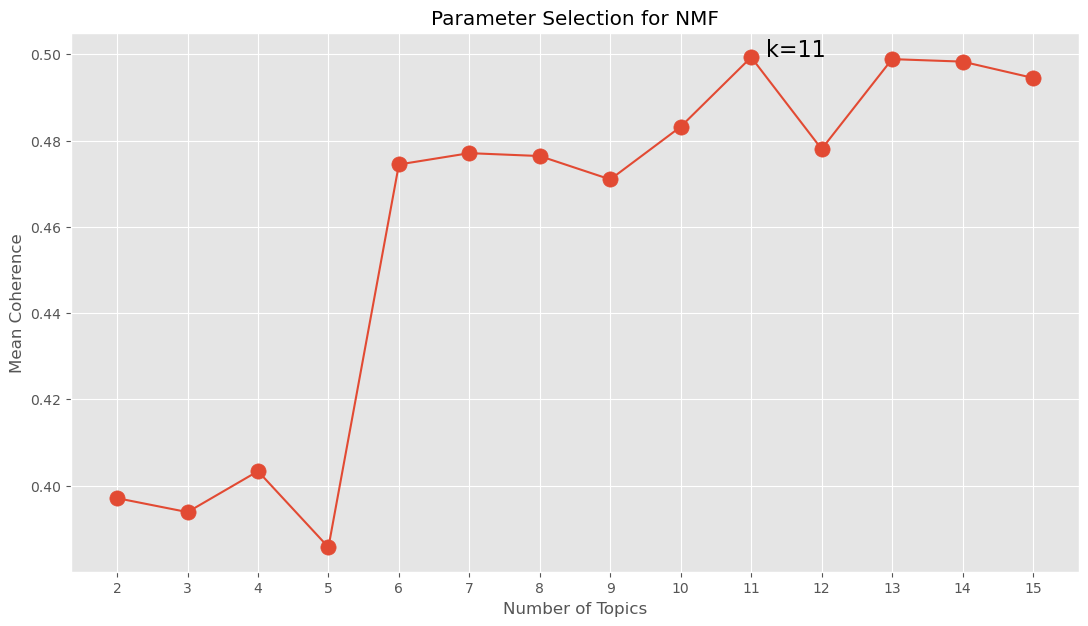

In [69]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter(k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate("k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.title('Parameter Selection for NMF')
plt.savefig('tune_parameter_nmf.png', bbox = 'tight')

In [70]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [71]:
for topic_index in range(k):
    descriptor = get_descriptor(terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % (topic_index+1, str_descriptor) )

Topic 01: diet, healthy, dairy, health, consumption, evidence, beneficial, debate, cookbook, latest
Topic 02: eat, meal, lot, fake, veggie, fish, vegetable, time, fruit, choose
Topic 03: burger, king, cooked, grill, impossible, patty, whopper, veggie, sausage, beef
Topic 04: food, processed, fast, junk, fake, healthy, health, company, impossible, news
Topic 05: animal, product, dairy, egg, industry, planet, cruelty, milk, human, save
Topic 06: alternative, free, cheese, option, dairy, meal, recipe, chicken, year, delicious
Topic 07: eating, day, health, year, feel, stopped, time, planet, start, week
Topic 08: vegetarian, eater, option, year, meal, flexitarian, restaurant, lot, dish, product
Topic 09: taste, good, real, texture, substitute, smell, stuff, fake, reason, love
Topic 10: people, lot, reason, veganism, hate, understand, choice, consumption, industry, reduce
Topic 11: protein, source, substitute, high, bean, pea, body, soy, fat, vegetable


Next steps 

--> expand contractions if TIME, remove stop words